Verifying the findings of [LMBiS-Net](https://arxiv.org/pdf/2309.04968v1.pdf)
<br>
Paper Link - https://arxiv.org/pdf/2309.04968v1.pdf
<br>

# Imports

In [1]:
import shutil
import random
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate
from pprint import pprint
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables and Helper Functions

In [3]:
# Global variables
EPOCHS_TO_TRAIN = 50
FIRST_HO = "1stHO"
SECOND_HO = "2ndHO"
IMAGE_SIZE = 512
DATASET_DIR = "/content/FIVES/"
DATASET_BATCH_SIZE = 4
TRAIN_IMAGES_DIR = f"{DATASET_DIR}/train/Original"
TRAIN_LABELS_DIR_1STHO = f"{DATASET_DIR}/train/Ground truth"
TRAIN_LABELS_DIR_2NDHO = f"{DATASET_DIR}/train_labels_{IMAGE_SIZE}"
TEST_IMAGES_DIR = f"{DATASET_DIR}/test/Original"
TEST_LABELS_DIR_1STHO = f"{DATASET_DIR}/test/Ground truth"
TEST_LABELS_DIR_2NDHO = f"{DATASET_DIR}/test_labels_{IMAGE_SIZE}/2ndHO"
CHECKPOINT_DIR = "checkpoints"
random.seed(42)

# Helper functions


def dice_coeff(y_true, y_pred, smooth=1):
    y_true = y_true / 255
    intersection = tf.keras.backend.sum(y_true * y_pred, axis=[2,3])
    sums = tf.keras.backend.sum(y_true, axis=[2,3]) + tf.keras.backend.sum(y_pred, axis=[2,3])
    dice = (2. * intersection + smooth) / (sums + smooth)
    return tf.keras.backend.mean(dice, axis=-1)

class Sensitivity(tf.keras.metrics.Metric):
    def __init__(self, name="sensitivity", **kwargs):
        super(Sensitivity, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.possible_positives = self.add_weight(name="pp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())


class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name="specificity", **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name="tn", initializer="zeros")
        self.possible_negatives = self.add_weight(name="pn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1 - y_true, 0, 1)))
        self.true_negatives.assign_add(true_negatives)
        self.possible_negatives.assign_add(possible_negatives)

    def result(self):
        return self.true_negatives / (self.possible_negatives + tf.keras.backend.epsilon())

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / 255
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return 2 * ((self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def iou(y_true, y_pred, smooth=tf.keras.backend.epsilon()):
    y_true = y_true / 255
    y_true_f = tf.keras.backend.batch_flatten(y_true)
    y_pred_f = tf.keras.backend.batch_flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f, axis=-1)
    union = tf.keras.backend.sum(y_true_f, axis=-1) + tf.keras.backend.sum(y_pred_f, axis=-1) - intersection
    return (intersection + smooth) / (union + smooth)

# Global variables
MODEL_COMPILE_ARGS = {
    "loss": dice_loss,
    "metrics": [
        dice_coeff,
        iou,
        #Sensitivity(),
        Specificity(),
        #F1Score(),
        tf.metrics.AUC(),
    ],
}


def preprocess_image(image):
    image = image / 255.0  # Assuming the original image values were in [0, 255]
    return image


def get_generator_from_dir(dir, color_mode="rgb"):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory=dir,
        labels=None,  # Labels are not inferred since they have different names
        label_mode=None,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=DATASET_BATCH_SIZE,
        color_mode=color_mode,
        shuffle=False,
    )

def save_checkpoint(model, model_type, epoch):
    # make sure checkpoints folder exists
    if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")
    # save model
    model.save("checkpoints/model_" + model_type + "_" + str(epoch) + ".keras")
    print("Checkpoint saved: ", "model_" + model_type + "_" + str(epoch) + ".keras")


def plot_model_history(model_history):
    # plot the loss and accuracy side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(model_history.history["loss"], label="Training Loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(model_history.history["dice_coeff"], label="Dice Coefficient")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(model_history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(model_history.history["val_dice_coeff"], label="Validation Dice Coefficient")
    plt.legend()
    plt.show()


def load_latest_checkpoint(model_to_load, eval=False) -> (tf.keras.Model, int):
    # find the checkpoint with the highest epochs naming format model_1stHO_100.keras
    checkpoints = os.listdir("checkpoints")
    checkpoints = [i for i in checkpoints if i.startswith("model_" + model_to_load)]

    if len(checkpoints) == 0:
        print("ERROR: No checkpoints found! for model: " + model_to_load)
        return None, None

    checkpoints.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

    print("Loading checkpoint: ", checkpoints[-1])
    latest_checkpoint_num_epochs = int(checkpoints[-1].split("_")[-1].split(".")[0])

    # load the model
    model = tf.keras.models.load_model("checkpoints/" + checkpoints[-1], compile=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=MODEL_COMPILE_ARGS.get("loss"),
        metrics=MODEL_COMPILE_ARGS.get("metrics"),
    )

    if eval:
        if model_to_load == FIRST_HO:
            test_dataset = test_dataset_1stHO
        else:
            test_dataset = test_dataset_2ndHO

        # evaluate the model
        print("Evaluating the model: " + checkpoints[-1])
        model.evaluate(test_dataset)

    return model, latest_checkpoint_num_epochs


def random_test(model_to_load, model, image_to_load=None):
    # visualize the predictions in a plot with input image model prediction and ground truth
    test_images = os.listdir(f"{TEST_IMAGES_DIR}/img")
    random_image = random.choice(test_images)
    image_index = random_image.split(".")[0].split("_")[-1]

    print("Selected Image: ", random_image)
    if image_to_load:
        random_image = image_to_load
        image_index = random_image.split(".")[0].split("_")[-1]
    image_path = f"{TEST_IMAGES_DIR}/img/" + random_image
    image = Image.open(image_path).convert("RGB")
    if model_to_load == FIRST_HO:
        label_path = f"{TEST_LABELS_DIR_1STHO}/img/" + image_index + "_1stHO.png"
    else:
        label_path = f"{TEST_LABELS_DIR_2NDHO}/img/Image_" + image_index + "_2ndHO.png"
    label = Image.open(label_path).convert("L")
    print("Image path: ", image_path)
    print("Label path: ", label_path)
    image = np.array(image)
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    prediction = np.squeeze(prediction, axis=0)

    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(image[0])
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(prediction)
    plt.subplot(133)
    plt.title("Ground Truth")
    plt.imshow(label)

## Image Augmentation


In [4]:
# Define the augmentation methods
def random_rotate(image, label1, label2):
    angle = random.randint(-180, 180)
    augmented_image = image.rotate(angle)
    augmented_label1 = label1.rotate(angle)
    augmented_label2 = label2.rotate(angle)
    return augmented_image, augmented_label1, augmented_label2


def random_crop(image, label1, label2):
    width, height = image.size
    crop_val = random.randint(width // 2, width)
    crop_x = random.randint(0, width - crop_val)
    crop_y = random.randint(0, height - crop_val)
    augmented_image = image.crop((crop_x, crop_y, crop_x + crop_val, crop_y + crop_val))
    augmented_label1 = label1.crop(
        (crop_x, crop_y, crop_x + crop_val, crop_y + crop_val)
    )
    augmented_label2 = label2.crop(
        (crop_x, crop_y, crop_x + crop_val, crop_y + crop_val)
    )
    return augmented_image, augmented_label1, augmented_label2


def random_brightness(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    augmented_image = Image.blend(image, image.point(lambda x: x * factor), 0.5)
    augmented_label1 = Image.blend(label1, label1.point(lambda x: x * factor), 0.5)
    augmented_label2 = Image.blend(label2, label2.point(lambda x: x * factor), 0.5)
    return augmented_image, augmented_label1, augmented_label2


def random_contrast(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    mean = np.mean(image)
    augmented_image = Image.blend(
        image, image.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    augmented_label1 = Image.blend(
        label1, label1.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    augmented_label2 = Image.blend(
        label2, label2.point(lambda x: (x - mean) * factor + mean), 0.5
    )
    return augmented_image, augmented_label1, augmented_label2


def random_flip(image, label1, label2):
    augmented_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_label1 = label1.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_label2 = label2.transpose(Image.FLIP_LEFT_RIGHT)
    return augmented_image, augmented_label1, augmented_label2

def random_hue(image, label1, label2):
    factor = random.uniform(0.5, 1.5)
    augmented_image = Image.blend(image, image.point(lambda x: x * factor), 0.5)
    return augmented_image, label1, label2

def random_augment(image, label1, label2):
    # Randomly choose one of the augmentation methods
    aug_methods = [
        random_rotate,
        random_crop,
        random_brightness,
        random_contrast,
        random_flip,
        random_hue,
    ]
    # random number of augmentations to perform
    number_of_augmentations_to_perform = random.randint(1, len(aug_methods))

    # choose a random augmentation method make sure it is not applied twice
    augmentations_to_perform = []
    for _ in range(number_of_augmentations_to_perform):
        aug_method = random.choice(aug_methods)
        while aug_method in augmentations_to_perform:
            aug_method = random.choice(aug_methods)
        augmentations_to_perform.append(aug_method)

    # apply the augmentation methods
    for aug_method in augmentations_to_perform:
        random.seed(42)
        image, label1, label2 = aug_method(image, label1, label2)

    return image, label1, label2

In [5]:
# split the images into train and test sets
# random.shuffle(images)
train_images = []
train_labels = []
test_images = []
test_labels = []

for i in os.listdir('/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original'):
  if i.endswith('.png'):
    train_images.append(i)

for i in os.listdir('/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original'):
  if i.endswith('.png'):
    test_images.append(i)

for i in os.listdir('/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth'):
  if i.endswith('.png'):
    test_labels.append(i)

for i in os.listdir('/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original'):
  if i.endswith('.png'):
    train_labels.append(i)
print("num train_images: ", len(train_images))
print("num test_images: ", len(test_images))
print("num train_labels: ", len(train_labels))
print("num test_labels: ", len(test_labels))

num train_images:  600
num test_images:  200
num train_labels:  600
num test_labels:  200


In [6]:
train_images[:10]

['5_A.png',
 '4_A.png',
 '1_A.png',
 '6_A.png',
 '3_A.png',
 '2_A.png',
 '7_A.png',
 '116_A.png',
 '89_A.png',
 '275_D.png']

In [7]:
train_labels[:10]

['5_A.png',
 '4_A.png',
 '1_A.png',
 '6_A.png',
 '3_A.png',
 '2_A.png',
 '7_A.png',
 '116_A.png',
 '89_A.png',
 '275_D.png']

In [8]:
test_images[:10]

['1_A.png',
 '52_D.png',
 '26_A.png',
 '53_D.png',
 '32_A.png',
 '22_A.png',
 '19_A.png',
 '80_D.png',
 '79_D.png',
 '74_D.png']

In [9]:
# Prepare directories
# if os.path.exists(DATASET_DIR):
#     shutil.rmtree(DATASET_DIR)

os.makedirs(f"{TRAIN_IMAGES_DIR}/img")
os.makedirs(f"{TRAIN_LABELS_DIR_1STHO}/img")
#os.makedirs(f"{TRAIN_LABELS_DIR_2NDHO}/img")
os.makedirs(f"{TEST_IMAGES_DIR}/img")
os.makedirs(f"{TEST_LABELS_DIR_1STHO}/img")
#os.makedirs(f"{TEST_LABELS_DIR_2NDHO}/img")

In [10]:
# Prepare Test set
for i in test_images:
    # resize and save
    image = Image.open("/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/" + i).convert("RGB")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image.save(f"{TEST_IMAGES_DIR}/img/" + i)
    #os.remove("STARE/" + i[0])

for i in test_labels:
    label1 = Image.open("/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/" + i).convert("L")
    label1 = label1.resize((IMAGE_SIZE, IMAGE_SIZE))
    label1.save(f"{TEST_LABELS_DIR_1STHO}/img/" + i)
    #os.remove("STARE/" + i)



In [11]:
print(f"Augmenting the training set and resizing to: {IMAGE_SIZE}x{IMAGE_SIZE}")
Aug_factor = 1
# Augment the training set
# Augment each one of them 37 times - to get approx the same number of images as the paper

assert len(train_images) == len(train_labels)
for i in range(len(train_images)):
    image = Image.open("/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/" + train_images[i]).convert("RGB")
    label1 = Image.open("/content/drive/MyDrive/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/" + train_labels[i]).convert("L")

    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    label1 = label1.resize((IMAGE_SIZE, IMAGE_SIZE))

    for j in range(1):
        augmented_image, augmented_label1, augmented_label2 = random_augment(
            image, label1, label1
        )
        augmented_image.save(
            f'{TRAIN_IMAGES_DIR}/img/' + train_images[i].split('.')[0] + str(j) + '.png'
        )
        augmented_label1.save(
            f'{TRAIN_LABELS_DIR_1STHO}/img/' + train_labels[i].split('.')[0] + str(j) + '.png'
        )

Augmenting the training set and resizing to: 512x512


# Dataset Loading

In [12]:
# Load train and test sets

# Train Set
print(TRAIN_LABELS_DIR_1STHO)
train_data_gen = get_generator_from_dir(TRAIN_IMAGES_DIR)
train_label_gen_1stHO = get_generator_from_dir(TRAIN_LABELS_DIR_1STHO, color_mode="grayscale")
#train_label_gen_2ndHO = get_generator_from_dir(TRAIN_LABELS_DIR_2NDHO, color_mode="grayscale")
train_data_gen = train_data_gen.map(lambda image: preprocess_image(image))
train_dataset = tf.data.Dataset.zip((train_data_gen, train_label_gen_1stHO))
#train_dataset_2ndHO = tf.data.Dataset.zip((train_data_gen, train_label_gen_2ndHO))

# Test Set
test_data_gen = get_generator_from_dir(TEST_IMAGES_DIR)
test_label_gen_1stHO = get_generator_from_dir(TEST_LABELS_DIR_1STHO, color_mode="grayscale")
#test_label_gen_2ndHO = get_generator_from_dir(TEST_LABELS_DIR_2NDHO, color_mode="grayscale")
test_data_gen = test_data_gen.map(lambda image: preprocess_image(image))
test_dataset_1stHO = tf.data.Dataset.zip((test_data_gen, test_label_gen_1stHO))
#test_dataset_2ndHO = tf.data.Dataset.zip((test_data_gen, test_label_gen_2ndHO))

# make a validation set
dataset_size = len(train_images) * Aug_factor
validation_percent = 10
validation_size = int(dataset_size * validation_percent / 100)
train_dataset_1stHO = train_dataset.shuffle(dataset_size)
#train_dataset_2ndHO = train_dataset_2ndHO.shuffle(dataset_size)
val_dataset_1stHO = train_dataset.take(validation_size)
#val_dataset_2ndHO = train_dataset_2ndHO.take(validation_size)
train_dataset_1stHO = train_dataset.skip(validation_size)
#train_dataset_2ndHO = train_dataset_2ndHO.skip(validation_size)



/content/FIVES//train/Ground truth
Found 600 files belonging to 1 classes.
Found 600 files belonging to 1 classes.
Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


(4, 512, 512, 3)
(4, 512, 512, 1)


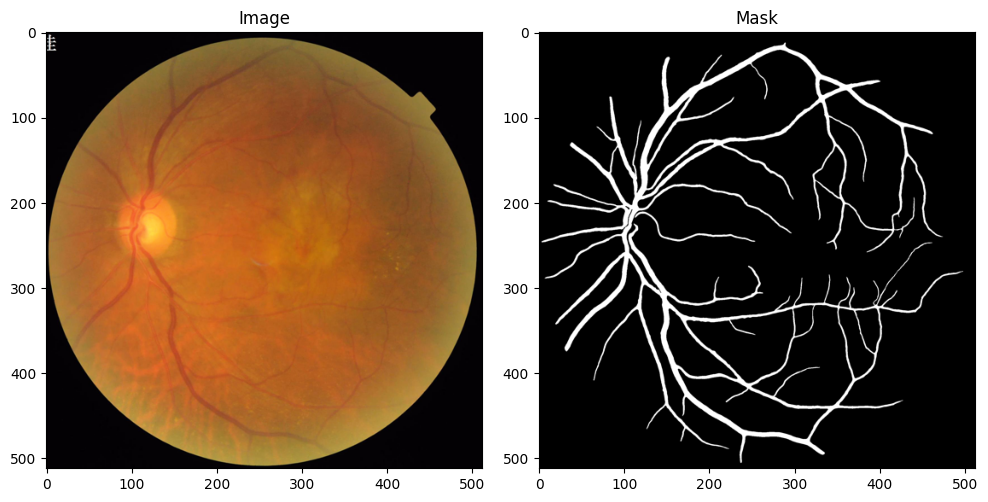

In [13]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(1)):
    plt.subplot(121)
    plt.title("Image")
    plt.imshow(image[3])

    plt.subplot(122)
    plt.title("Mask")
    plt.imshow(label[3], cmap='gray')
    print(image.shape)
    print(label.shape)
plt.tight_layout()
plt.show()

# Model Architecture

In [14]:
def prepare_fresh_model():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    input_data = Input(shape=input_shape)

    def multipath_feature_extraction_block(inputs):
        # Define kernel sizes for 1x1, 3x3, and 5x5 convolutions
        kernel_sizes = [1, 3, 5]
        pathway_outputs = []

        for kernel_size in kernel_sizes:
            conv = Conv2D(64, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(inputs)
            conv = BatchNormalization()(conv)
            pathway_outputs.append(conv)

        aggregated_output = tf.keras.layers.Add()(pathway_outputs)
        pathway_outputs = []

        # Run convolutions a second time.
        for kernel_size in kernel_sizes:
            conv = Conv2D(64, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(aggregated_output)
            conv = BatchNormalization()(conv)
            pathway_outputs.append(conv)

        aggregated_output = tf.keras.layers.Add()(pathway_outputs)

        return aggregated_output

    # Encoder Block
    def encoder_block(inputs, filters):
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        #x = MaxPooling2D(pool_size=(2, 2))(x)
        return x

    # Encoder Block with Multipath block
    def encoder_block_w_multipath(inputs, filters):
        x = multipath_feature_extraction_block(inputs)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        # Potentially re-add maxpool here.
        return x

    def max_pool(inputs):
        x = MaxPooling2D(pool_size=(2, 2))(inputs)
        return x

    encoder_stage1 = encoder_block(input_data, 32)
    maxpool1 = max_pool(encoder_stage1)

    encoder_stage2 = encoder_block_w_multipath(maxpool1, 64)
    maxpool2 = max_pool(encoder_stage2)

    encoder_stage3 = encoder_block_w_multipath(maxpool2, 128)
    maxpool3 = max_pool(encoder_stage3)

    def botteneck_block(inputs, filters):
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        return x

    # Bottleneck Layer
    bottleneck = botteneck_block(maxpool3, 64)

    # Decoder Block
    def decoder_block(inputs, skip_connection, filters):
        x = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
        x = Concatenate()([x, skip_connection])
        x = BatchNormalization()(x)
        x = multipath_feature_extraction_block(x)
        return x

    decoder1 = decoder_block(bottleneck, encoder_stage3, 128)
    decoder2 = decoder_block(decoder1, encoder_stage2, 64)

    # Decoder 3
    x = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder2)
    x = Concatenate()([x, encoder_stage1])
    x = BatchNormalization()(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    #x = BatchNormalization()(x)

    model = tf.keras.Model(inputs=input_data, outputs=x)
    return model

In [15]:
def get_fresh_models():
    # load fresh Model
    model_1stHO = prepare_fresh_model()
    model_2ndHO = tf.keras.models.clone_model(model_1stHO)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model_1stHO.compile(optimizer = optimizer, loss = MODEL_COMPILE_ARGS.get("loss"), metrics = MODEL_COMPILE_ARGS.get("metrics"))
    model_2ndHO.compile(optimizer = optimizer, loss = MODEL_COMPILE_ARGS.get("loss"), metrics = MODEL_COMPILE_ARGS.get("metrics"))

    return model_1stHO, model_2ndHO

# Model Training

In [16]:
# Start Fresh - make sure to run Cells under Model Architecture to start fresh
continue_training = False
model_1stHO, model_2ndHO = get_fresh_models()

In [19]:
model_1stHO.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['batch_normalization[0][0

Save a checkpoint to continue training as without saving between re runs of fit function the epoch count for save model will not work as intended, it relies on the saved models to figureout how many epochs have been run, it cannot judge how many epochs have been run from the history object

## Train for 1stHO

In [20]:
# Train the model with the first label
history_1stHO = model_1stHO.fit(train_dataset, epochs=10, validation_data=val_dataset_1stHO)
if continue_training:
    epoch_num = model_1stHO_num_epochs + EPOCHS_TO_TRAIN
else:
    epoch_num = EPOCHS_TO_TRAIN
save_checkpoint(model_1stHO, FIRST_HO, epoch_num)

Epoch 1/10
150/150 [==============================] - 146s 689ms/step - loss: 0.4713 - dice_coeff: 0.5287 - iou: 0.3689 - specificity: 0.8465 - auc: 0.8708 - val_loss: 0.9109 - val_dice_coeff: 0.0891 - val_iou: 3.7844e-07 - val_specificity: 0.9985 - val_auc: 0.4989
Epoch 2/10
150/150 [==============================] - 102s 683ms/step - loss: 0.2473 - dice_coeff: 0.7527 - iou: 0.6043 - specificity: 0.9716 - auc: 0.8854 - val_loss: 0.7667 - val_dice_coeff: 0.2333 - val_iou: 0.1428 - val_specificity: 0.9767 - val_auc: 0.5738
Epoch 3/10
150/150 [==============================] - 103s 684ms/step - loss: 0.1839 - dice_coeff: 0.8161 - iou: 0.6870 - specificity: 0.9849 - auc: 0.8740 - val_loss: 0.4549 - val_dice_coeff: 0.5451 - val_iou: 0.4120 - val_specificity: 0.9836 - val_auc: 0.7057
Epoch 4/10
150/150 [==============================] - 112s 747ms/step - loss: 0.1787 - dice_coeff: 0.8213 - iou: 0.6935 - specificity: 0.9858 - auc: 0.8665 - val_loss: 0.2582 - val_dice_coeff: 0.7418 - val_iou:

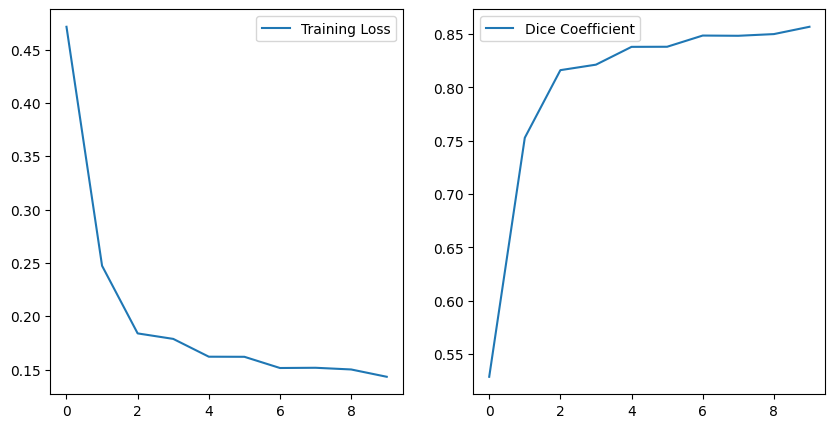

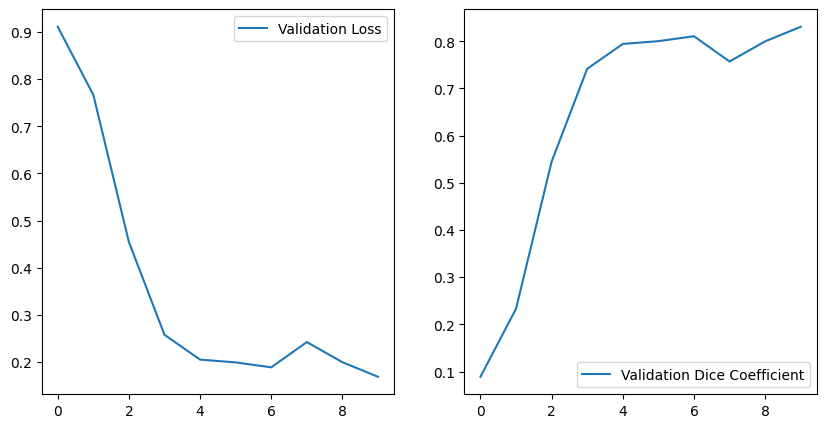

In [21]:
# 50
plot_model_history(history_1stHO)

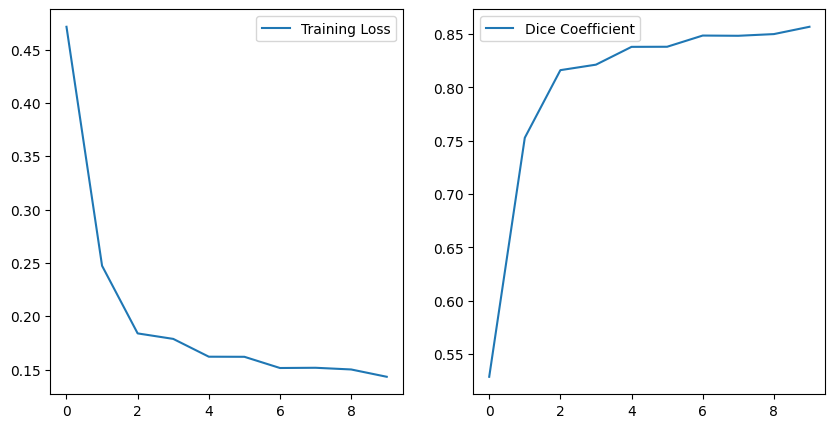

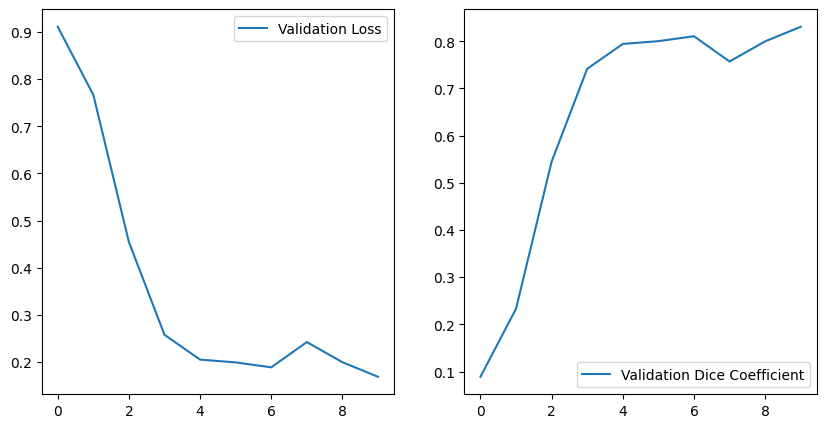

In [22]:
# 100
plot_model_history(history_1stHO)

# Model Evaluation


## Evaluate for 1stHO

In [24]:
model_to_load = FIRST_HO
eval_model,_ = load_latest_checkpoint(model_to_load, eval=True)

Loading checkpoint:  model_1stHO_50.keras
Evaluating the model: model_1stHO_50.keras
50/50 [==============================] - 11s 196ms/step - loss: 0.1853 - dice_coeff: 0.8147 - iou: 0.7030 - specificity: 0.9959 - auc: 0.8231


1/1 [==============================] - 1s 991ms/step


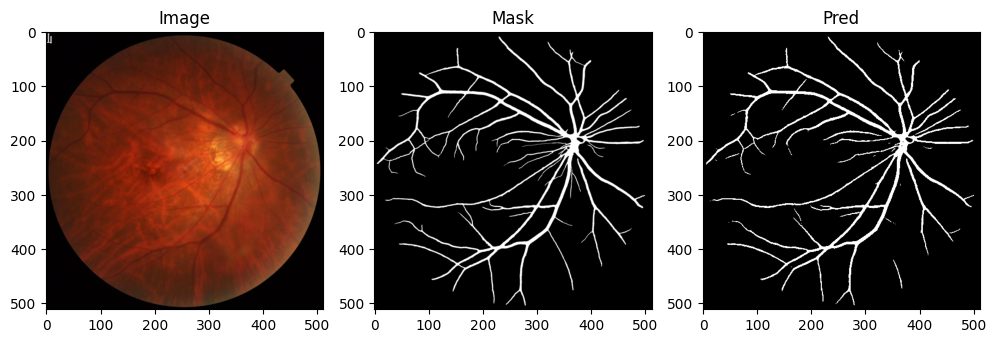

In [25]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(1)):
    op = model_1stHO.predict(image)
    plt.subplot(131)
    plt.title("Image")
    plt.imshow(image[0])

    plt.subplot(132)
    plt.title("Mask")
    plt.imshow(label[0], cmap='gray')


    plt.subplot(133)
    plt.title("Pred")
    plt.imshow(op[0], cmap='gray')


plt.tight_layout()
plt.show()